In [3]:
import json
import os
import torch
import numpy as np
import cv2
import albumentations
import albumentations.pytorch
import radiate
# from torchvision.io import read_image

class Radiate_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_folder, train_mode, transform = False):
        self.root_dir = data_folder
        self.folders = []
        self.transform = transform
        # print(len(os.listdir(self.root_dir)))
        self.train_mode = train_mode
        for curr_dir in os.listdir(self.root_dir):
            with open(os.path.join(self.root_dir, curr_dir, 'meta.json')) as f:
                meta = json.load(f)
            if meta["set"] == train_mode:
                self.folders.append(curr_dir)
        self.folders.sort()
        # print(self.folders)
        # print(len(self.folders))
        
        self.radar_dicts = self.get_radar_dicts(self.folders)
        # print(len(self.radar_dicts))
        # self.datas = []
        self.data_idx = 0        
        # for idx, _ in enumerate(self.radar_dicts):
        #     record_init = {}
        #     record_init["data_idx"] = self.data_idx
        #     record_init["img"] = self.radar_dicts[idx]
        #     record_init["train_mode"] = self.train_mode
        #     self.data_idx += 1
        #     self.datas.append(record_init)
        
    def __len__(self):
        return len(self.radar_dicts)
    
    def __getitem__(self, idx):
        radar_dict = self.radar_dicts[idx]
        img = cv2.imread(radar_dict["file_name"])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # print(radar_dict["img"])
        boxes = []
        boxes_angle = []
        bbox_OOD = []
        category_id = []
        angle = []
        target = {}
        img_info = {}
        num_objs = 0
        difficulties = []

        for i in range(len(radar_dict['annotations'])):
            boxes.append(radar_dict['annotations'][i]['bbox'])
            boxes_angle.append(radar_dict['annotations'][i]['bbox_angle'])
            bbox_OOD.append(radar_dict['annotations'][i]['bbox_OOD'])
            category_id.append(radar_dict['annotations'][i]['category_id'])
            difficulties.append(['0'])
            num_objs += 1
        
        boxes = torch.as_tensor(boxes, dtype = torch.float32)
        angle = torch.as_tensor(angle, dtype = torch.float32)
        bbox_OOD = torch.as_tensor(bbox_OOD, dtype = torch.float32)
        category_id = torch.as_tensor(category_id, dtype = torch.float32)
        iscrowd = torch.zeros((num_objs,), dtype = torch.int64)
    
        target["file_name"] = radar_dict['file_name']
        target["frame_number"] = radar_dict['frame_number']
        target["folder_name"] = radar_dict['folder_name']
        target["bboxes"] = boxes
        target["bboxes_angle"] = boxes_angle
        target["bboxes_OOD"] = bbox_OOD
        target["category_id"] = category_id
        target['image_id'] = radar_dict['image_id']
        # target["iscrowd"] = iscrowd 
        target["difficulty"] = difficulties
        # labels = category_id
        img_info["folder_name"] = radar_dict['folder_name']
        img_info["frame_number"] = radar_dict['frame_number']
        
        radiate_sdk = radiate.Sequence(os.path.join(self.root_dir, target["folder_name"]), config_file='config/config.yaml')
        timestamp = np.float64(radiate_sdk.timestamp_radar['time'][int(target['frame_number'][:-4])-1])
        output = radiate_sdk.get_from_timestamp(timestamp, get_annotations=False)
        lidar_img = output['sensors']['lidar_bev_image']
        if self.transform:
            data_transform = albumentations.Compose([
                albumentations.CenterCrop(256,256)],
                # albumentations.pytorch.transforms.ToTensorV2()],
                bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
                )
            data_transform_yolo = albumentations.Compose([
                albumentations.CenterCrop(256,256)],
                # albumentations.pytorch.transforms.ToTensorV2()],
                bbox_params=albumentations.BboxParams(format='yolo', label_fields=['labels']),
                )
            data_transform_lidar = albumentations.Compose([
                albumentations.CenterCrop(256,256)])

            transformed = data_transform(image = img, bboxes = target['bboxes'], labels = target["category_id"])
            transformed_2 = data_transform_yolo(image = img, bboxes = target['bboxes_angle'], labels = target["category_id"])
            transformed_3 = data_transform_lidar(image = lidar_img)
            img = transformed['image']
            target['bboxes'] = torch.as_tensor(transformed['bboxes'], dtype=torch.float32)
            target['category_id'] = torch.as_tensor(transformed['labels'], dtype=torch.float32)
            target['bboxes_angle'] = torch.as_tensor(transformed_2['bboxes'], dtype=torch.float32)
            lidar_img = transformed_3['image']
            # labels = transformed['labels']
        
        return img, lidar_img, target, img_info
    


    def gen_boundingbox_OBB(self, bbox, angle):
        theta = np.deg2rad(-angle)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        points = np.array([[bbox[0], bbox[1]],
                           [bbox[0] + bbox[2], bbox[1]],
                           [bbox[0] + bbox[2], bbox[1] + bbox[3]],
                           [bbox[0], bbox[1] + bbox[3]]]).T

        cx = bbox[0] + bbox[2] / 2
        cy = bbox[1] + bbox[3] / 2
        T = np.array([[cx], [cy]])

        points = points - T
        points = np.matmul(R, points) + T
        points = points.astype(float)
        
        return points

    def gen_boundingbox_HBB(self, bbox, angle):
        theta = np.deg2rad(-angle)
        R = np.array([[np.cos(theta), -np.sin(theta)],
                      [np.sin(theta), np.cos(theta)]])
        points = np.array([[bbox[0], bbox[1]],
                           [bbox[0] + bbox[2], bbox[1]],
                           [bbox[0] + bbox[2], bbox[1] + bbox[3]],
                           [bbox[0], bbox[1] + bbox[3]]]).T

        cx = bbox[0] + bbox[2] / 2
        cy = bbox[1] + bbox[3] / 2
        T = np.array([[cx], [cy]])

        points = points - T
        points = np.matmul(R, points) + T
        points = points.astype(float)

        min_x = np.min(points[0, :])
        min_y = np.min(points[1, :])
        max_x = np.max(points[0, :])
        max_y = np.max(points[1, :])

        return min_x, min_y, max_x, max_y
    
    def get_radar_dicts(self, folders):
        dataset_dicts = []
        idd = 0
        folder_size = len(folders)
        file_lenght = 0
        for idx, folder in enumerate(folders):
            # radiate_sdk = radiate.Sequence(os.path.join(self.root_dir, folder), config_file='config/config.yaml')
            radar_folder = os.path.join(self.root_dir, folder, 'Navtech_Cartesian')
            annotation_path = os.path.join(self.root_dir,
                                           folder, 'annotations', 'annotations.json')
            with open(annotation_path, 'r') as f_annotation:
                annotation = json.load(f_annotation)

            folder_number = idx
            radar_files = os.listdir(radar_folder)
            radar_files.sort()
            # print(radar_files)
            
            for frame_number in range(len(radar_files)):
                # if folder_number == 0:
                #     print(frame_number)
                record = {}
                objs = []
                bb_created = True
                idd += 1
                filename = os.path.join(
                    radar_folder, radar_files[frame_number])
                # print(filename)
                if (not os.path.isfile(filename)):
                    print(filename)
                    continue
                record["folder_name"] = folder
                record["frame_number"] = radar_files[frame_number]
                record["file_name"] = filename
                record["image_id"] = idd-1
                record["height"] = 1152
                record["width"] = 1152
                record["folder_number"] = folder_number

                for object in annotation:
                    if (object['bboxes'][frame_number]):
                        class_obj = object['class_name']
                        if (class_obj != 'pedestrian' and class_obj != 'group_of_pedestrians'):
                            bbox = object['bboxes'][frame_number]['position']
                            angle = object['bboxes'][frame_number]['rotation']
                            # bb_created = True
                            # if cfg.MODEL.PROPOSAL_GENERATOR.NAME == "RRPN":
                            min_x, min_y, max_x, max_y = self.gen_boundingbox_HBB(bbox, angle)

                            # print(bbox, angle.shape)
                            points = self.gen_boundingbox_OBB(bbox, angle)
                            x1 = points[0][0]
                            y1 = points[1][0]
                            x2 = points[0][1]
                            y2 = points[1][1]
                            x3 = points[0][2]
                            y3 = points[1][2]
                            x4 = points[0][3]
                            y4 = points[1][3]
                            
                            
                            cx = (bbox[0] + bbox[2] / 2) / 1152
                            cy = (bbox[1] + bbox[3] / 2) / 1152
                            wid = (bbox[2]) / 1152
                            hei = (bbox[3]) / 1152
                            
                            obj = {
                                "bbox": [min_x, min_y, max_x, max_y],
                                "bbox_angle": [cx, cy, wid, hei, angle],
                                "bbox_OOD": [x1, y1, x2, y2, x3, y3, x4, y4],
                                "category_id": 0,
                                "iscrowd": 0
                            }

                            objs.append(obj)
                # if bb_created:
                record["annotations"] = objs
                dataset_dicts.append(record)
        # print(dataset_dicts)
        return dataset_dicts
    

In [4]:
# from dataset import Radiate_Dataset
import torch
import albumentations
import argparse
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from PIL import Image
import numpy as np
import cv2

parser = argparse.ArgumentParser()
parser.add_argument("--data_folder", help="root folder with radiate dataset", 
                    default='/workspace/dataset/radiate', type=str)

parser.add_argument("--save_folder", help="root for save directory",
                    default = "/workspace/JS/faster_rcnn_JS/checkpoint", type=str)

parser.add_argument("--backbone", help="backbone network",
                    default='VGG16', type=str)

parser.add_argument("--mgpu", help="using multigpu",
                    default=False, type=bool)

parser.add_argument("--train_mode", help="dataset mode ('train_good_weather', 'train_good_and_bad_weather', 'test')",
                    default='train_good_and_bad_weather', type=str)

parser.add_argument("--checkpoint", help="checkpoint root",
                    default=None, type=str)

parser.add_argument("--batch_size", help="batch size",
                    default=4, type=int)

parser.add_argument("--num_workers", help="number of workers for loading data in the DataLoader",
                    default=8, type=int)

parser.add_argument("--save_rate", help="save rate for the model",
                    default=5000, type=int)

parser.add_argument("--max_iter", help="Maximum number of iterations",
                    default = 50000, type=int)

parser.add_argument("--loss_lambda", help="loss balance coefficient",
                    default=1, type=int)

parser.add_argument("--lr", help="learning rate",
                    default=0.00025, type=float)

parser.add_argument("--momentum", help="momentum",
                    default=0.9, type=float)

parser.add_argument("--weight_decay", help="weight decay",
                    default=0.0001, type=float)

parser.add_argument("--GAMMA", help="lr GAMMA",
                    default=0.1, type=float)

parser.add_argument("--decay_step", help="steps for decay lr",
                    default=[25000, 35000], type=list)


args = parser.parse_args(args=[])
data_folder = args.data_folder
train_mode = args.train_mode

save_folder = args.save_folder
backbone = args.backbone
checkpoint = args.checkpoint
mgpu = args.mgpu

batch_size = args.batch_size
workers = args.num_workers
max_iteration = args.max_iter
save_rate = args.save_rate

loss_lambda = args.loss_lambda
momentum = args.momentum
lr = args.lr
weight_decay = args.weight_decay
decay_step = args.decay_step
decay_GAMMA = args.GAMMA

In [5]:
dataset_gb = Radiate_Dataset(data_folder, train_mode, transform=False)

1787 1563272997.599283 705 1563272997.8707557


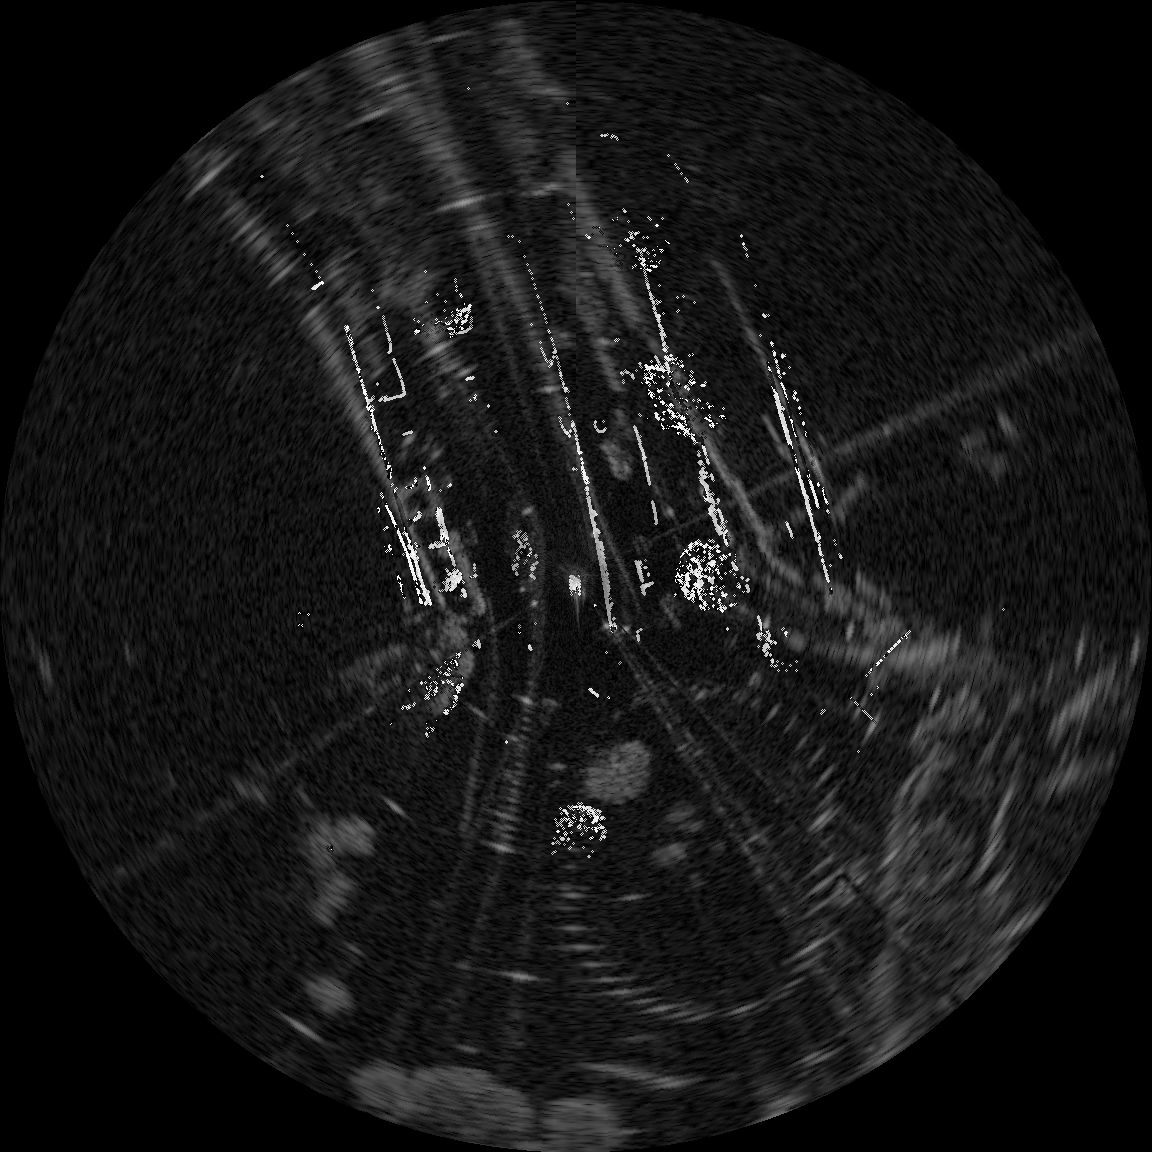

(1152, 1152, 3)


In [6]:
radar_img, lidar_img, _, _ = dataset_gb[1424]
add_img = radar_img + lidar_img
cv2.imwrite('1.2.png', add_img)
img1 = Image.fromarray(radar_img)
img2 = Image.fromarray(lidar_img)
img3 = Image.fromarray(add_img)
# img1.show()
# img2.show()
img3.show()
print(lidar_img.shape)

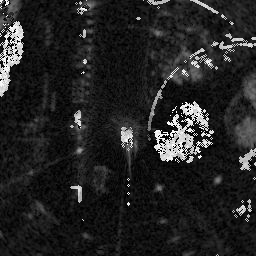

In [5]:
add_img = radar_img + lidar_img
cv2.imwrite('1.2.png', add_img)
img1 = Image.fromarray(radar_img)
img2 = Image.fromarray(lidar_img)
img3 = Image.fromarray(add_img)
# img1.show()
# img2.show()
img3.show()

In [6]:
str_format = '{:06d}'
from tqdm import tqdm
for i in tqdm(np.arange(600,1000,1)):
    # print(i)
    radar_img, lidar_img, _, _ = dataset_gb[i]
    add_img = radar_img + lidar_img

    cv2.imwrite('./test2/add_{:06d}.png'.format(i), add_img)


100%|██████████| 400/400 [02:27<00:00,  2.71it/s]


In [8]:
import cv2
import os
import numpy as np
import radiate
# import radiatelane
import json
from PIL import Image

root_dir = '/workspace/dataset/radiate/'
# sequence_name = 'tiny_foggy'

# time (s) to retrieve next frame
dt = 0.25

# get the test data
folders_train_g = []
folders_train_gb = []
folders_test = []
for curr_dir in os.listdir(root_dir):
    with open(os.path.join(root_dir, curr_dir, 'meta.json')) as f:
        meta = json.load(f)
    if meta["set"] == "train_good_weather":
        folders_train_g.append(curr_dir)
    elif meta["set"] == "train_good_and_bad_weather":
        folders_train_gb.append(curr_dir)
    elif meta["set"] == "test":
        folders_test.append(curr_dir)

folders_train_gb.sort()
folders_train_g.sort()
folders_test.sort()


In [ ]:
save_name = '{:05d}.png'
dt = 0.25

for sequence_name in folders_train_g:
    seq = radiate.Sequence(os.path.join(root_dir, sequence_name), config_file='config/config.yaml')
    save_folder = os.path.join('./results',sequence_name)
    os.makedirs(save_folder, exist_ok=True)
    # print(sequence_name)
    # print(len(seq.timestamps))
    # break
    for i, t in enumerate(np.arange(seq.init_timestamp, seq.end_timestamp, dt)):
    # for i, t in enumerate(seq.timestamps):
        save_path = os.path.join(save_folder, save_name.format(i))
        # print(sequence_name, "sequence:", t)
        t = np.float64(t)
        # print(type(t))
        # break
        output = seq.get_from_timestamp(t, get_annotations=False)
        try:
            radar_img = output['sensors']['radar_cartesian']
            lidar_img = output['sensors']['lidar_bev_image']
            add_img = radar_img + lidar_img
            # img1 = Image.fromarray(radar_img).resize((256,256))
            # img2 = Image.fromarray(lidar_img).resize((256,256))
            # img3 = Image.fromarray(add_img).resize((256,256))
            # img1.show()
            # img2.show()
            # img3.show()
            cv2.imwrite(save_path, add_img)
        except:
            continue

        # break
        # str_format = '{:06d}'
    #     try:
    #         length.append(output['id_radar'])
    #     except:
    #         break
    #     # print(str_format.format(output['id_radar']))
    # print(len(length))

